# Imports, Setup

In [40]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import yfinance as yf
from numpy import linalg as LA
from sklearn.cluster import KMeans
from statsmodels.tsa.stattools import coint
from itertools import combinations
import matplotlib.dates as mdates
from datetime import datetime

In [41]:
cap_path = '/Users/tuckeringlefield/Desktop/Data_Science/Math_4920/Stocks_Data/cap_data_from_shardar.csv'
price_path = "/Users/tuckeringlefield/Desktop/Data_Science/Math_4920/Stocks_Data/price_data_from_shardar.csv"

# Reading Data:
prices_df = pd.read_csv(price_path, index_col='date')
caps_df = pd.read_csv(cap_path, index_col='date')

# Drop troubled stock...
prices_df.drop(["MGI", "MDLZ", "DWA", "ICE"], axis=1, inplace=True)
caps_df.drop(["MGI", "MDLZ", "DWA", "ICE"], axis=1, inplace=True)

prices_df.head()
caps_df.head()

,ATW,A,AA,AAAB,AABC,AAC1,AACC,AACE,AACH,AADI,...,ZVIA,ZVOI,ZVRA,ZVUE,ZVXI,ZY,ZYME,ZYNE,ZYXI,ZZ
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0.265785,14.803789,NaN,0.002968,0.000000,0.055383,NaN,0.074688,NaN,NaN,...,NaN,NaN,NaN,NaN,0.010821,NaN,NaN,NaN,NaN,NaN
2000-01-04,0.355094,13.938379,NaN,0.001050,0.000000,0.093997,NaN,0.036322,NaN,NaN,...,NaN,NaN,NaN,NaN,0.001050,NaN,NaN,NaN,NaN,NaN
2000-01-05,0.597657,15.593232,NaN,0.002262,0.000000,0.082724,NaN,0.042248,NaN,NaN,...,NaN,NaN,NaN,NaN,0.002725,NaN,NaN,NaN,NaN,NaN
2000-01-06,0.377474,6.688876,NaN,0.003307,0.000000,0.071145,NaN,0.022496,NaN,NaN,...,NaN,NaN,NaN,NaN,0.006309,NaN,NaN,NaN,NaN,NaN
2000-01-07,0.698268,8.061751,NaN,0.001843,0.000426,0.061952,NaN,0.005193,NaN,NaN,...,NaN,NaN,NaN,NaN,0.033459,NaN,NaN,NaN,NaN,NaN


In [42]:
prices_df.index = pd.to_datetime(prices_df.index)

# Get the initial start and end date
start_date = prices_df.index[0]
end_date = prices_df.index[-1]

# Download additional data:
spy_data = yf.download('SPY', start=start_date, end=end_date, interval='1d')
spy_data = pd.DataFrame(spy_data["Adj Close"])
spy_data.rename({"Adj Close": 'SPY'}, inplace=True, axis=1)

# Set up dataframes:
prices_with_market = prices_df.merge(spy_data, how='left', left_index=True, right_index=True)

[*********************100%%**********************]  1 of 1 completed


# Building Dataset

In [43]:
# Pulling rougly the first half of data
num_rows = len(prices_df)
print(f'Original Length: {num_rows}')
train_df = prices_df[:np.round(num_rows/2).astype(int)]
num_rows = len(train_df)
print(f'Train Length: {num_rows}')

Original Length: 5787
Train Length: 2894


In [44]:
# Let's identify stocks with no null values
complete_stock_list = train_df.columns
non_null_stocks = []
for stock in complete_stock_list:
    # get the count of nulls
    null_count = train_df[stock].isnull().sum()
    if null_count == 0:
        non_null_stocks.append(stock)

print(len(complete_stock_list))
print(len(non_null_stocks))

10806
2467


In [45]:
math.comb(2467, 8)

33643293680092024164060

we have 2,467 available stocks and 33,643,293,680,092,024,164,060 options

how do we choose?

we'll come back to this but maybe the finance professor could help us pick...

here are some groups based on sectors/industries for now:
1. Technology (Software & Hardware)
- AAPL (Apple)
- AMD (Advanced Micro Devices)
- AKAM (Akamai Technologies)
- AMZN (Amazon)
- ADI (Analog Devices)
- ADBE (Adobe)
- ADSK (Autodesk)
- ATVI (Activision Blizzard)
2. Healthcare & Biotech
- ABMD (Abiomed)
- AMGN (Amgen)
- BIIB (Biogen Idec)
- AGN1 (Allergan)
- BAX (Baxter International)
- ABBV (AbbVie)
- GILD (Gilead Sciences)
- GSK (GlaxoSmithKline)
3. Consumer Goods & Retail
- COST (Costco)
- WMT (Walmart)
- HD (Home Depot)
- MCD (McDonald's)
- NKE (Nike)
- TGT (Target)
- LOW (Lowe’s)
- F (Ford)
4. Energy & Utilities
- EOG (EOG Resources)
- XOM (ExxonMobil)
- COP (ConocoPhillips)
- CVX (Chevron)
- ENB (Enbridge)
- WMB (Williams Companies)
- OXY (Occidental Petroleum)
- HES (Hess)
5. Financials
- JPM (JPMorgan Chase)
- BAC (Bank of America)
- GS (Goldman Sachs)
- MS (Morgan Stanley)
- AXP (American Express)
- C (Citigroup)
- PNC (PNC Financial Services)
- WFC (Wells Fargo)
6. Industrial & Manufacturing
- CAT (Caterpillar)
- GE (General Electric)
- DE (Deere & Co.)
- ITW (Illinois Tool Works)
- MMM (3M)
- UTX (United Technologies)
- LMT (Lockheed Martin)
- RTX (Raytheon Technologies)
7. Consumer Services
- DIS (Walt Disney)
- CMCSA (Comcast)
- AT&T (T)
- SBUX (Starbucks)
- LUV (Southwest Airlines)
- DAL (Delta Air Lines)
- UAL (United Airlines)
- AAL (American Airlines)
8. Real Estate
- AVB (AvalonBay Communities)
- SPG (Simon Property Group)
- EQR (Equity Residential)
- PLD (Prologis)
- ESS (Essex Property Trust)
- O (Realty Income)
- NNN (National Retail Properties)
- STAG (STAG Industrial)

# Building Functions

- calculate correlation matrix
- cluster the matrix
- perform these operations monthly

In [46]:
def get_corr_matrix(DataFrame):
    return DataFrame.corr()

In [47]:
def cluster(df, num_clusters):
    A = abs(df.corr().values)
    D = np.diag(A.sum(axis=1))
    L = D - A
    eigenvalues, eigenvectors = LA.eig(L)
    X = eigenvectors[:,:num_clusters]
    kmeans = KMeans(n_clusters=num_clusters, random_state=2, n_init=20).fit(X)

    cluster_dict = {}

    # Iterate over the indices of cluster_list
    for i in range(len(kmeans.labels_)):
        cluster_number = kmeans.labels_[i]
        stock_name = df.columns[i]

        # Check if cluster_number is already a key in the dictionary
        if cluster_number in cluster_dict:
            cluster_dict[cluster_number].append(stock_name)
        else:
            cluster_dict[cluster_number] = [stock_name]
    return cluster_dict

In [82]:
def monthly_clustering(DataFrame, months_to_run):
    # Set up the log
    cluster_log = {}
    # Get the list of timestamps (assuming the index is a list of Timestamps)
    index = DataFrame.index.tolist()
    # Debug: Check the type and contents of index
    #print(f"Index type: {type(index)}")
    #print(f"Index sample (first 10 entries): {index[:10]}")
    # Start from the first timestamp
    first_day = index[0]
    #print(f"Starting with first day: {first_day}")
    index_position = 0  # Keeps track of the current position in the list of timestamps
    for _ in range(months_to_run):
        # Calculate the last day of the month based on the current first day
        last_day_of_month = pd.Timestamp(first_day.year, first_day.month, 1) + pd.offsets.MonthEnd(0)
        #print(f"Last day of month: {last_day_of_month}")  # Debug  
        # Cluster
        cluster_entry = cluster(DataFrame[first_day:last_day_of_month], 2)
        cluster_log[last_day_of_month] = cluster_entry 
        # Find the index position of the last day of the month in the list of timestamps
        last_day_position = None
        current_last_day = last_day_of_month
        while last_day_position is None:  # Keep searching until we find a match
            try:
                last_day_position = next(
                    i for i, t in enumerate(index) if t.date() == current_last_day.date()
                )
                #print(f"Last day position found: {last_day_position} for date {current_last_day}")  # Debug
            except StopIteration:
                # Backtrack by one day and try again
                #print(f"Date {current_last_day} not found in index, trying the previous day.")
                current_last_day -= pd.Timedelta(days=1)
                # If backtracking goes too far, raise an error
                if current_last_day < first_day:
                    raise ValueError(
                        f"Could not find a suitable last day for the month starting at {first_day}. "
                        "Backtracking exceeded the first day."
                    )
        # Move to the next day after the last day of this month
        try:
            first_day = index[last_day_position + 1]
            #print(f"Moving to the next first day: {first_day}")  # Debug
        except IndexError:
            #print(f"Error: Attempted to access index position {last_day_position + 1}, but index is out of range.")
            raise ValueError(f"Index out of range after position {last_day_position}.")
    return cluster_log    

In [83]:
def cluster_viz(cluster_dict):
    # Flatten the dictionary into a list of records
    records = []
    for timestamp, groups in cluster_dict.items():
        for group, stocks in groups.items():
            for stock in stocks:
                records.append({'timestamp': timestamp, 'stock': stock, 'group': group})
    
    # Create a DataFrame
    temp_df = pd.DataFrame(records)
    
    # Get all unique stocks and groups
    all_stocks = sorted(temp_df['stock'].unique())
    all_groups = sorted(temp_df['group'].unique())
    
    # Create the plot with an axis object
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Scatter plot: timestamps on x, stocks on y, groups as color
    for group in all_groups:
        group_data = temp_df[temp_df['group'] == group]
        ax.scatter(
            group_data['timestamp'],  # x-axis
            group_data['stock'],      # y-axis
            label=f"Group {group}",   # Legend label
            s=50, alpha=0.7          # Marker size and transparency
        )
    
    # Add vertical lines at x-axis ticks
    for tick in ax.get_xticks():
        ax.vlines(tick, ymin=0, ymax=len(all_stocks), color='grey', linestyle='--')
    
    # Customize plot
    ax.set_title("Stock Clustering Over Time")
    ax.set_xlabel("Time")
    ax.set_ylabel("Stocks")
    ax.set_xticks(ax.get_xticks())  # Ensure ticks are set correctly
    plt.xticks(rotation=45)
    ax.legend(title="Cluster")
    
    plt.tight_layout()
    plt.show()


In [89]:
def convert_log_to_df(cluster_dict):
    # Create a list to hold DataFrame rows
    rows = []
    # Populate the rows with timestamp, stock, and cluster
    for timestamp, clusters in cluster_dict.items():
        for cluster_id, stocks in clusters.items():
            for stock in stocks:
                rows.append({'timestamp': timestamp, 'stock': stock, 'cluster': cluster_id})
    # Create the DataFrame
    df = pd.DataFrame(rows)
    # Pivot the DataFrame to get the desired format
    result = df.pivot(index='timestamp', columns='stock', values='cluster')
    return result

# Testing Functions

In [84]:
tech_sector_stocks = train_df[['AAPL','AMD','AKAM','AMZN','ADI','ADBE','ADSK','ATVI']]

In [108]:
cluster_log = monthly_clustering(tech_sector_stocks, 120)

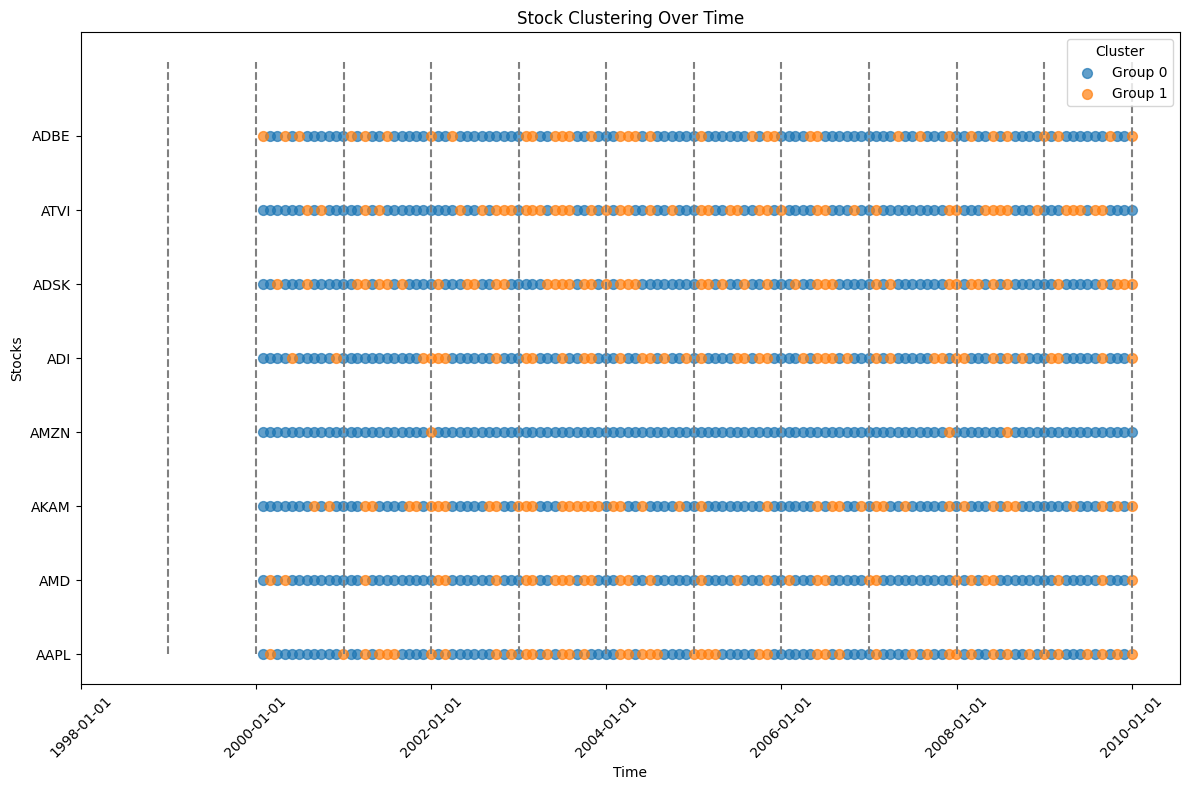

In [109]:
cluster_viz(cluster_log)

In [93]:
data = convert_log_to_df(cluster_log)
data.head(20)

stock,AAPL,ADBE,ADI,ADSK,AKAM,AMD,AMZN,ATVI
timestamp,,,,,,,,
2000-01-31,0,1,0,0,0,0,0,0
2000-02-29,1,0,0,0,0,1,0,0
2000-03-31,0,0,0,1,0,0,0,0
2000-04-30,0,1,0,0,0,1,0,0
2000-05-31,0,0,1,0,0,0,0,0
2000-06-30,0,1,0,0,0,0,0,0
2000-07-31,0,0,0,1,0,0,0,1
2000-08-31,0,0,0,0,1,0,0,0
2000-09-30,0,0,0,0,0,0,0,1


In [100]:
columns = data.columns
for col in columns:
    print(f'{col} mean: {data[col].mean()}')
    print(f'{col} std dev: {data[col].std()}')

AAPL mean: 0.34
AAPL std dev: 0.47851812069840644
ADBE mean: 0.3
ADBE std dev: 0.4629100498862757
ADI mean: 0.26
ADI std dev: 0.44308749769345207
ADSK mean: 0.4
ADSK std dev: 0.4948716593053935
AKAM mean: 0.44
AKAM std dev: 0.501426536422407
AMD mean: 0.28
AMD std dev: 0.4535573676110727
AMZN mean: 0.02
AMZN std dev: 0.14142135623730948
ATVI mean: 0.36
ATVI std dev: 0.4848732213850611


<Axes: xlabel='date'>

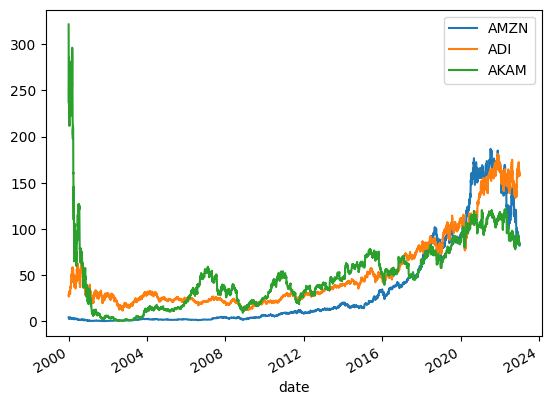

In [107]:
prices_with_market[['AMZN','ADI','AKAM']].plot()